<a href="https://colab.research.google.com/github/erlanig/ml-train/blob/main/Copy_of_bismillahcapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
# Upload api kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizkyfahreza","key":"5c5deb65fe64a44af1c87afe7da7b566"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
amanbarthwal/imdb-movies-data                                       IMDB Movies Dataset                                   8MB  2024-05-16 18:43:48           1638         28  1.0              
prasad22/weather-data                                               Weather Data                                         43MB  2024-05-18 14:27:35           1045         24  1.0              
jainaru/electric-vehicle-population                                 Electric Vehicle Data                                 6MB  2024-05-21 18:40:16            791         25  1.0              
rahulvyasm/netflix-movies-and-tv-shows  

In [ ]:
!kaggle datasets download -d 'fuadkahfi/dataset-tanah'

Dataset URL: https://www.kaggle.com/datasets/fuadkahfi/dataset-tanah
License(s): unknown
 99% 221M/224M [00:04<00:00, 70.6MB/s]
100% 224M/224M [00:04<00:00, 58.0MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('dataset-tanah.zip', 'r')

dataset_zip.extractall()

dataset_zip.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

from tensorflow.keras.applications import Xception

In [ ]:
# Direktori dataset setelah ekstraksi
base_dir = 'Tanah'

# Pengaturan untuk ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # Membagi 10% data untuk validasi
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Ukuran gambar yang akan diubah
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 792 images belonging to 8 classes.
Found 88 images belonging to 8 classes.


In [ ]:
# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [ ]:
# freeze or not the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# # Fine tuning
# # pilih salah satu
# # layer awal - 100
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# # dari layer 100 hingga akhir
# for layer in base_model.layers[100:]:
#     layer.trainable = True

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 21914672 (83.60 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 20861480 (79.58 MB)
________

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # Tambah jumlah epoch
    # callbacks=[reduce_lr]
)


Epoch 1/50
24/24 [==============================] - 92s 4s/step - loss: 1.6687 - accuracy: 0.4132 - val_loss: 1.2364 - val_accuracy: 0.6094
Epoch 2/50
24/24 [==============================] - 88s 4s/step - loss: 1.1309 - accuracy: 0.6026 - val_loss: 0.8428 - val_accuracy: 0.7188
Epoch 3/50
24/24 [==============================] - 88s 4s/step - loss: 0.9096 - accuracy: 0.6908 - val_loss: 0.8419 - val_accuracy: 0.7031
Epoch 4/50
24/24 [==============================] - 87s 4s/step - loss: 0.8635 - accuracy: 0.6947 - val_loss: 0.8280 - val_accuracy: 0.7188
Epoch 5/50
24/24 [==============================] - 83s 3s/step - loss: 0.8579 - accuracy: 0.7132 - val_loss: 0.5770 - val_accuracy: 0.8750
Epoch 6/50
24/24 [==============================] - 84s 3s/step - loss: 0.7752 - accuracy: 0.7145 - val_loss: 0.7155 - val_accuracy: 0.7500
Epoch 7/50
24/24 [==============================] - 83s 3s/step - loss: 0.6888 - accuracy: 0.7671 - val_loss: 0.6901 - val_accuracy: 0.6875
Epoch 8/50
24/24 [==

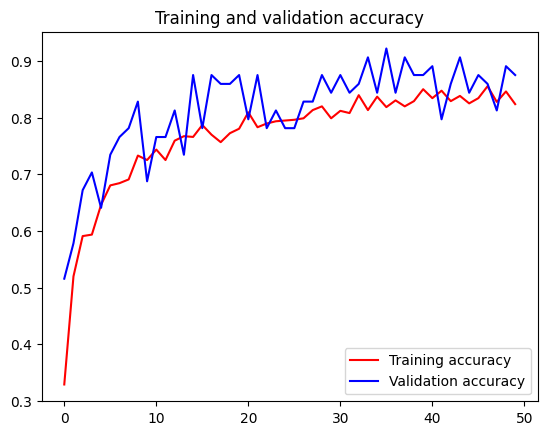

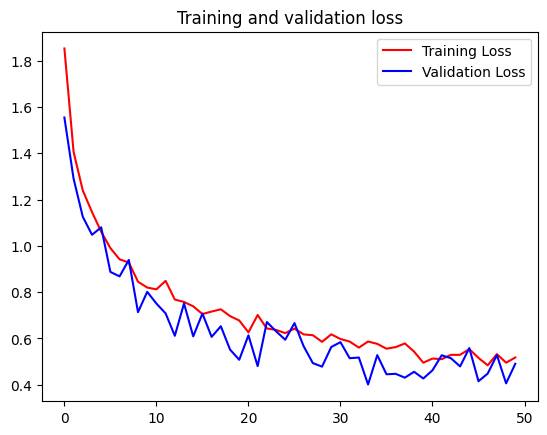

In [ ]:
import matplotlib.pyplot as plt

# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy*100:.2f}%')


3/3 [==============================] - 8s 2s/step - loss: 0.3968 - accuracy: 0.9318
Validation accuracy: 93.18%


In [ ]:
# Membuat prediksi
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Muat dan proses gambar
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi gambar
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[class_idx]

# Contoh prediksi
img_test = files.upload()   # Ganti dengan path gambar yang ingin diprediksi
for filename in img_test.keys():
  predicted_class = predict_image(filename)
  print(f'The predicted class is: {predicted_class}')


Saving test_pasir2.jpeg to test_pasir2.jpeg
1/1 [==============================] - 0s 119ms/step
The predicted class is: 04-Humus
